In [ ]:
from sklearn.datasets import fetch_california_housing

housing_data = fetch_california_housing()
descr = housing_data['DESCR']
feature_names = housing_data['feature_names']
data = housing_data['data']
target = housing_data['target']

In [ ]:
print(descr)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [ ]:
## write all of your imports here
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
#from sklearn.impute import KNNImputer, SimpleImputer
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


In [ ]:
# Data exploration
data=pd.DataFrame(data, columns=feature_names) #I prefer to work with pd
target=pd.Series(target, name='target')
data.head() #to look at the data and features
#later we would like to use the relation of bedrooms to rooms
#and occupied to popultion, because they are related and not independent
#in feature engineering
#for now we assume all features are normally distributed and we can do normalization

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
target.shape[0],data.shape #to validate the sizes

(20640, (20640, 8))

In [ ]:
#define the percentage of missing data, that above it the entries would be removed
print(f'Total Number of Null Values in the Set: {data.isna().sum().sum()}')
print(f'Total Number of Null Values in the Set: {target.isna().sum()}')
print(f'Total Number of Duplicated Values in the Set: {data.duplicated().sum()}')


Total Number of Null Values in the Set: 0
Total Number of Null Values in the Set: 0
Total Number of Duplicated Values in the Set: 0


In [ ]:
#no need to impute or remove missing lines\columns
#no need to remove duplicated (pd has this function)
#below example for dropping of missing columns above 85%,
#and later imputation by types (numric and categorical) using pipeline of sklearn.pipeline
'''
data=pd.concat([data, target], axis=1)
missing_data = data.isna().sum()/data.shape[0] * 100

print("Columns in Train set with more than 85% missing values:")
print(missing_data[missing_data > 85])

cat_cols = [col for col in data.select_dtypes('object').columns if col!='target']
num_cols = [col for col in data.select_dtypes('number').columns]
print(f'Categorical columns:\n {cat_cols}\n')
print(f'Numeric columns:\n {num_cols}')

numeric_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, num_cols),
                ('cat', categorical_transformer, cat_cols)])

data_imputed = pd.DataFrame(preprocessor.fit_transform(df[num_cols + cat_cols]), columns=num_cols + cat_cols)

print("Missing values after imputation:")
print(data_imputed.isnull().sum())

return data_imputed
'''

'\ndata=pd.concat([data, target], axis=1)\nmissing_data = data.isna().sum()/data.shape[0] * 100\n\nprint("Columns in Train set with more than 85% missing values:")\nprint(missing_data[missing_data > 85])\n\ncat_cols = [col for col in data.select_dtypes(\'object\').columns if col!=\'target\']\nnum_cols = [col for col in data.select_dtypes(\'number\').columns]\nprint(f\'Categorical columns:\n {cat_cols}\n\')\nprint(f\'Numeric columns:\n {num_cols}\')\n\nnumeric_transformer = Pipeline(steps=[(\'imputer\', KNNImputer(n_neighbors=3))])\n\ncategorical_transformer = Pipeline(steps=[(\'imputer\', SimpleImputer(strategy=\'most_frequent\')),\n            (\'ordinal\', OrdinalEncoder(handle_unknown=\'use_encoded_value\', unknown_value=-1))])\n\npreprocessor = ColumnTransformer(\n            transformers=[\n                (\'num\', numeric_transformer, num_cols),\n                (\'cat\', categorical_transformer, cat_cols)])\n\ndata_imputed = pd.DataFrame(preprocessor.fit_transform(df[num_cols +

In [ ]:
#The preproccesing was moved above split data, because normalization should be
#perfomed on overall df, not for each train or test set seperatly

class Preprocessor():

    def __init__(self, X, y):
      self.data_full = pd.concat([X, y], axis=1)
      self.cols=self.data_full.columns

      self.normalized=0
      self.scaled=0
      self.new_features=0


    def normalize(self):

      data = self.data_full

      scaler = preprocessing.StandardScaler().fit(data)
      data_scaled = scaler.transform(data)
      #print('type after normalization', type(data_scaled))
      data_scaled_1 = pd.DataFrame(data_scaled,columns=self.cols)
      #print('type after pd', type(data_scaled))
      self.data_full = data_scaled_1

      #mark that normalization is done for outliers removal
      self.normalized = 1

      return data_scaled_1.iloc[:,:-1], data_scaled_1.iloc[:,-1]

    def remove_outliers(self):
      if self.normalized==0:
        data, target = self.normalize()
        data_norm = pd.concat([data, target], axis=1)
      elif self.scaled==1:
        print('Outliers should be remover before scaling')
        pass
      else:
        data_norm = self.data_full
        #remove all above 3 std after normalization
        data_scaled = data_norm[(data_norm < 3).all(axis=1)]
        #remove all below -3 std after normalization
        data_scaled_2 = data_scaled[(data_scaled > (-3)).all(axis=1)]
        self.data_full = data_scaled_2

        return data_scaled_2.iloc[:,:-1], data_scaled_2.iloc[:,-1]

    def scale(self):
      if self.normalized==0:
        data, target = self.normalize()
        data_norm = pd.concat([data, target], axis=1)
      else:
        data_scaled = preprocessing.minmax_scale(self.data_full, axis=0)

      #print('type after normalization', type(data_scaled))
      data_scaled_3 = pd.DataFrame(data_scaled,columns=self.cols)
      #print('type after pd', type(data_scaled))
      self.data_norm=data_scaled_3
      return data_scaled_3.iloc[:,:-1], data_scaled_3.iloc[:,-1]
      self.scaled=1

    def feature_engineering(self):
      #in this case I would hardcode the names, because it is custom features
      # new features: relation of bedrooms to rooms, occupied to popultion,
      # because they are related and not independent
      # and in the regression we must use IID, or at least an aproximation to IID
      # both of the above pair are removed
      # reagridng: Latitude 	Longitude
      # best case -use geospatial libraries and create some density function, etc
      #because we would use regression, we would leave them here, but cut
      #the decimal places to make it less precise, to avoid parks, lakes, etc
      data = self.data_full

      target=data['target']
      data['rel_bedrooms_rooms']=data['AveBedrms']/data['AveRooms']
      data['rel_Occu_Pop']=data['AveOccup']/data['Population']
      new_data=data.drop(columns=['AveBedrms','AveRooms','AveOccup','Population', 'target']).round({"Latitude":3, "Longitude" :3})
      new_data=pd.concat([new_data, target], axis=1)

      self.new_features=1
      self.data_full = new_data
      self.cols = new_data.columns

      return new_data.iloc[:,:-1], new_data.iloc[:,-1]


In [ ]:
#to create new features
prep_objct = Preprocessor(data, target)
X_prep_0, y_prep_0 = prep_objct.feature_engineering()
print('\n After features; \n', X_prep_0.head(3), '\n The target features: \n', y_prep_0.head(3))
print('\n min, max; \n', X_prep_0.min(),'\n', X_prep_0.max(), '\n The target min, max:\n', np.max(y_prep_0),'\n', np.min(y_prep_0))



 After features; 
    MedInc  HouseAge  Latitude  Longitude  rel_bedrooms_rooms  rel_Occu_Pop
0  8.3252      41.0     37.88    -122.23            0.146591      0.007937
1  8.3014      21.0     37.86    -122.22            0.155797      0.000879
2  7.2574      52.0     37.85    -122.24            0.129516      0.005650 
 The target features: 
 0    4.526
1    3.585
2    3.521
Name: target, dtype: float64

 min, max; 
 MedInc                  0.499900
HouseAge                1.000000
Latitude               32.540000
Longitude            -124.350000
rel_bedrooms_rooms      0.100000
rel_Occu_Pop            0.000164
dtype: float64 
 MedInc                 15.0001
HouseAge               52.0000
Latitude               41.9500
Longitude            -114.3100
rel_bedrooms_rooms      1.0000
rel_Occu_Pop            1.0000
dtype: float64 
 The target min, max:
 5.00001 
 0.14999


In [ ]:
# Process your data here
X_prep_1, y_prep_1 = prep_objct.normalize()

#to validate the normalization
print('\n After normalization; \n', X_prep_1.head(3), '\n The target normalization\n', y_prep_1.head(3))
print('\n min, max; \n', X_prep_1.min(), '\n', X_prep_1.max(), '\n The target min, max:\n', np.max(y_prep_1),'\n', np.min(y_prep_1))

#remove outliers
X_prep_2, y_prep_2 = prep_objct.remove_outliers()

#to validate the normalization without outliers
print('\n After outliers removal; \n', X_prep_2.head(3), '\n The target: \n', y_prep_2.head(3))
print('\n min, max; \n', X_prep_2.min(),'\n', X_prep_2.max(), '\n The target min, max:\n', np.max(y_prep_2),'\n', np.min(y_prep_2))


#scaling of normalized features without outliers
data, target = prep_objct.scale()

#to validate the scaling
print('\n After scaling; \n', data.head(3), '\n The target scaling: \n', target.head(3))
print('\n min, max; \n', data.min(),'\n', data.max(), '\n The target min, max:\n', np.max(target),'\n', np.min(target))




 After normalization; 
      MedInc  HouseAge  Latitude  Longitude  rel_bedrooms_rooms  rel_Occu_Pop
0  2.344766  0.982143  1.052548  -1.327835           -1.145833      0.289936
1  2.332238 -0.607019  1.043185  -1.322844           -0.987175     -0.227065
2  1.782699  1.856182  1.038503  -1.332827           -1.440115      0.122422 
 The target normalization
 0    2.129631
1    1.314156
2    1.258693
Name: target, dtype: float64

 min, max; 
 MedInc               -1.774299
HouseAge             -2.196180
Latitude             -1.447568
Longitude            -2.385992
rel_bedrooms_rooms   -1.948819
rel_Occu_Pop         -0.279391
dtype: float64 
 MedInc                 5.858286
HouseAge               1.856182
Latitude               2.958068
Longitude              2.625280
rel_bedrooms_rooms    13.562517
rel_Occu_Pop          72.961335
dtype: float64 
 The target min, max:
 2.540410937738136 
 -1.6626408492053844

 After outliers removal; 
      MedInc  HouseAge  Latitude  Longitude  rel_bedr

In [ ]:
def trainValidTestSplit(X, y):
  #function for splitting data into train (60%), test (20%) and validation set (20%)
  #there are faster functions to do it directly by numpy, but it is longer code, usefull on big data or online proccesses
  x_inter, X_test, y_inter, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)
  X_train, X_valid, y_train, y_valid = train_test_split(x_inter,y_inter,test_size = 0.25,train_size =0.75)

  return X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
# Do not change this code
X_train, X_valid, X_test, y_train, y_valid, y_test = trainValidTestSplit(data, target)

In [ ]:
#validate splitting by sizes
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((11930, 6), (3977, 6), (3977, 6), (11930,), (3977,), (3977,))

In [ ]:
class Visualization():

    def __init__(self, X, y):
      self.data = X
      self.target = y
      self.data_full=pd.concat([X, y], axis=1)
      self.cols = self.data.columns

    def plot_ordered(self):
      #creates plots of each feature against target by ordered target
      sorted=self.data_full.sort_values(by=['target'], ascending=True)
      data_sort=sorted.iloc[:,:-1]
      target_sort=sorted.iloc[:,-1]
      fig, axs = plt.subplots(int(np.ceil(len(self.cols)/2)), 2, figsize= [10,6], sharex=True, layout="constrained")

      i=0; j=0 ;n=0
      for attribute, measurement in data_sort.items():
            axs[i, j].plot(target_sort, measurement)
            axs[i, j].set_title(f'Target vs {attribute}')
            axs[i, j].set_ylabel(attribute)
            axs[i, j].set_xlabel('target')
            axs[i, j].grid(True)
            if j==0: j=1
            elif j==1: j=0
            n=n+0.5
            i=int(np.floor(n))

      plt.show()

    def scatter(self):
      #creates plots of each feature against target
      fig, axs = plt.subplots(int(np.ceil(len(self.cols)/2)), 2, figsize= [10,6], sharex=True, layout="constrained")

      i=0; j=0 ;n=0
      for attribute, measurement in self.data.items():
            axs[i, j].scatter(self.target, measurement, s=3)
            axs[i, j].set_title(f'Target vs {attribute}')
            axs[i, j].set_ylabel(attribute)
            axs[i, j].set_xlabel('target')
            axs[i, j].grid(True)
            if j==0: j=1
            elif j==1: j=0
            n=n+0.5
            i=int(np.floor(n))
            if i == int(np.ceil(len(self.cols)/2)) : break
      plt.show()

      pass


In [ ]:
# Run your visualizations here.
vis=Visualization(data, target)

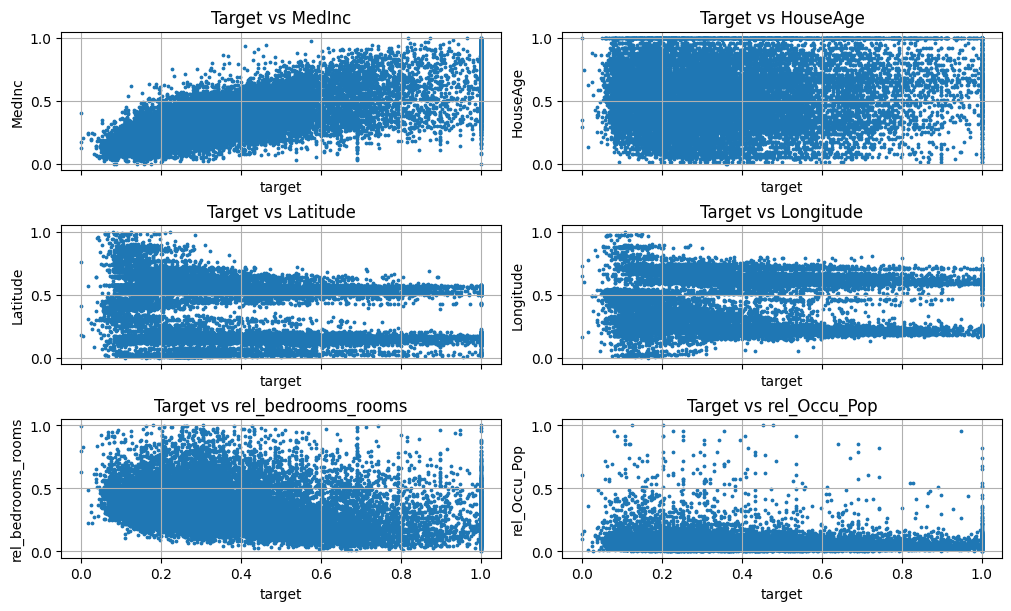

In [ ]:
vis.scatter()
#we can see the relations between different features and target

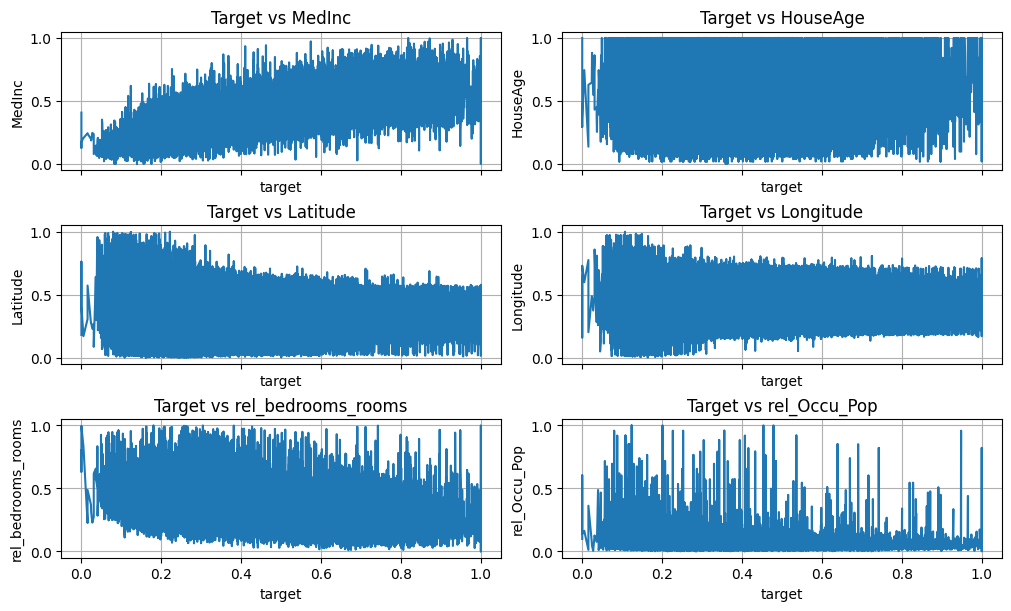

In [ ]:
vis.plot_ordered()
#not much additional information than the scatter plot

In [ ]:
# model generation
class Model():

    def __init__(self, X=None, y=None, model_type='linear', alpha=0.1, max_iter=1000):
        self.X = X
        self.y = y
        self.model_type = model_type
        self.alpha = alpha
        self.max_iter = max_iter

        if model_type == 'linear':
            self.model = linear_model.SGDRegressor(alpha=alpha, max_iter=max_iter)
        elif model_type == 'ridge':
            self.model = linear_model.Ridge(alpha=alpha, max_iter=max_iter)
        elif model_type == 'lasso':
            self.model = linear_model.Lasso(alpha=alpha, max_iter=max_iter)
        else:
            raise ValueError("Invalid model type")

    def fit(self, X, y, **fit_params):
        # Fit the model on the training data
        self.model.fit(X, y, **fit_params)
        # Pass **fit_params to the underlying model for GridSearch

    def predict(self, X):
        return self.model.predict(X)

    def loss(self, X, y):
        y_pred = self.predict(X)
        return mean_squared_error(y, y_pred)

    def get_params(self, deep=True):
        return {
            'model_type': self.model_type,
            'alpha': self.alpha,
            'max_iter': self.max_iter
        }
    def set_params(self, **params):
        # Update the parameters of the Model object
        if 'model_type' in params:
            self.model_type = params['model_type']
        if 'alpha' in params:
            self.alpha = params['alpha']
        if 'max_iter' in params:
            self.max_iter = params['max_iter']

        # Recreate the internal model based on the updated parameters
        if self.model_type == 'linear':
            self.model = linear_model.SGDRegressor(alpha=self.alpha, max_iter=self.max_iter)
        elif self.model_type == 'ridge':
            self.model = linear_model.Ridge(alpha=self.alpha, max_iter=self.max_iter)
        elif self.model_type == 'lasso':
            self.model = linear_model.Lasso(alpha=self.alpha, max_iter=self.max_iter)
        else:
            raise ValueError("Invalid model type")

        return self # Return self to conform with scikit-learn's estimator API



In [ ]:
#A class for performing hyperparameter tuning using GridSearchCV.

class HyperparameterTuner:

  def __init__(self, model, param_grid, scoring='neg_mean_squared_error', cv=5):
    #Initializes the HyperparameterTuner object.
    self.model = model
    self.param_grid = param_grid
    self.scoring = scoring
    self.cv = cv

  def tune(self, X_train, y_train, X_valid, y_valid):
    #Performs hyperparameter tuning using GridSearchCV.
    grid_search = GridSearchCV(
        estimator=self.model,
        param_grid=self.param_grid,
        scoring=self.scoring,
        cv=self.cv,
        n_jobs=-1  # Use all available cores
        )
    grid_search.fit(X_train, y_train)

    # Print the best parameters and score
    print("Best parameters found: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    # Evaluate the best model on the validation set
    best_model = grid_search.best_estimator_
    valid_loss = best_model.loss(X_valid, y_valid)
    print("Validation loss:", valid_loss)

    return best_model

In [ ]:
# In this cell you should create an instance of model with the optimal hyperparameters you found.

# Create a Model object
model = Model(X_train, y_train)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'model_type': ['linear', 'ridge', 'lasso'],
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [1000, 5000, 10000]
}

# Create a HyperparameterTuner object
tuner = HyperparameterTuner(model, param_grid)

# Perform hyperparameter tuning
best_model = tuner.tune(X_train, y_train, X_valid, y_valid)


Best parameters found:  {'alpha': 0.001, 'max_iter': 1000, 'model_type': 'ridge'}
Best score:  -0.019750175482614592
Validation loss: 0.02162839851886371


In [ ]:
#Presenting results
# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Comments on the values meaning:
# MSE represents the average squared difference between the predicted and actual values.
# A lower MSE indicates a better fit of the model to the data.
# RMSE is the square root of MSE, and it provides a measure of the error in the same units as the target variable.
# In this case, RMSE represents the average difference between the predicted and actual median house prices.
# Lower RMSE values indicate better prediction accuracy.


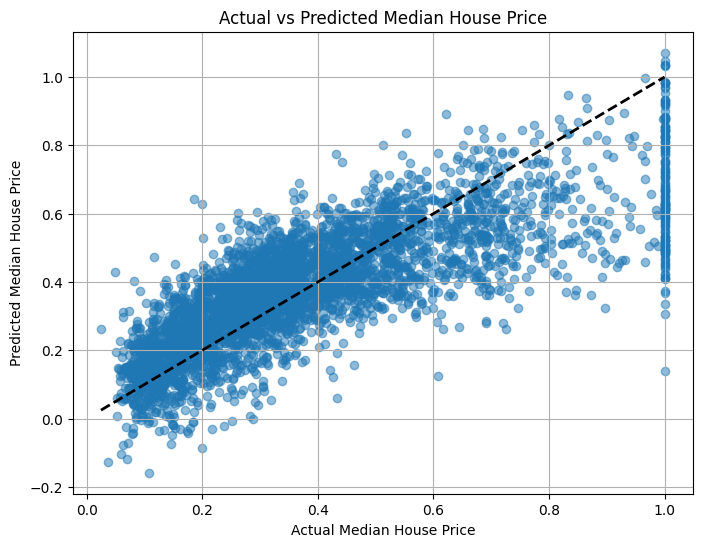

In [ ]:
# present results of the best model regression as plt plot and elaborate on the result

import matplotlib.pyplot as plt

# Plotting the predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Median House Price")
plt.ylabel("Predicted Median House Price")
plt.title("Actual vs Predicted Median House Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for perfect prediction
plt.grid(True)
plt.show()

# The scatter plot shows the relationship between the actual and predicted median house prices.
# Ideally, the points should fall along a diagonal line, indicating perfect prediction.
# The plot helps to visualize the model's performance and identify any patterns or outliers, and the overall trend.
# This visualization provides insights into the model's accuracy and potential areas for improvement.

#Improvments
# we could use in future more compatible models for comparison with the regression
# latitude and longitude have specific pattern as seen from the plots above, not very linear against the target.
# HouseAge isn't very representative for linear dependency with the target
# we could use other new composed fetures, or stay with part of the initial ones
# decision tree may be very good option here, particulary XGBoost.
